In [3]:
import time
import numpy as np
from tqdm import tqdm
import pandas as pd
import scipy as sp
from theano import tensor as tt
import pymc3 as pm
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import jit
from jax.scipy.stats import norm

from run_scripts.load_data import load_traintest_hier
from conformal_bayes import conformal_Bayes_functions as cb
from conformal_bayes import Bayes_MCMC_functions as bmcmc

%reload_ext autoreload
%autoreload 2

# Load Data 

In [47]:
x,y,x_test,y_test,y_plot,n,d = load_traintest_hier(1,"radon",100)
K = np.shape(np.unique(x[:,1]))[0]
print(K)

85


# Conformal

In [49]:
beta_post = jnp.array(np.load("samples/beta_post_hier_{}.npy".format('radon')))[0]
intercept_post = jnp.array(np.load("samples/intercept_post_hier_{}.npy".format('radon')))[0]
sigma_post = jnp.array(np.load("samples/sigma_post_hier_{}.npy".format('radon')))[0]

### Define x_test  

In [126]:
x_test = np.zeros((2*K,2))
for k in range(K):
    x_test[2*k:2*k + 2,1] = k
    x_test[2*k,0] = 0
    x_test[2*k+1,0]= 1

n_test = np.shape(x_test)[0]

pi_cb = np.zeros((n_test,np.shape(y_plot)[0]))
region_cb = np.zeros((n_test,np.shape(y_plot)[0]))
length_cb = np.zeros(n_test)
band_bayes = np.zeros((n_test,2))
length_bayes = np.zeros(n_test)

dy = y_plot[1]- y_plot[0]

### Compute rank plots

In [174]:
groups_train = np.unique(x[:,1]).astype('int')
K_train = np.size(groups_train)
n_groups = np.zeros(K_train)

for k in (range(K_train)):
    ind_group = (x[:,1] == groups_train[k])
    n_groups[k] =np.sum(ind_group)
    
alpha_k = 1.1*(1/(n_groups + 1))
print(alpha_k)

[0.22       0.02075472 0.275      0.1375     0.22       0.275
 0.07333333 0.22       0.1        0.15714286 0.18333333 0.22
 0.15714286 0.07333333 0.22       0.36666667 0.22       0.08461538
 0.0171875  0.275      0.11       0.15714286 0.36666667 0.11
 0.07333333 0.01037736 0.15714286 0.18333333 0.275      0.09166667
 0.18333333 0.22       0.22       0.275      0.1375     0.36666667
 0.11       0.22       0.18333333 0.22       0.12222222 0.55
 0.11       0.1375     0.07857143 0.18333333 0.36666667 0.11
 0.07857143 0.55       0.22       0.275      0.275      0.04583333
 0.12222222 0.275      0.15714286 0.22       0.22       0.36666667
 0.03333333 0.18333333 0.275      0.09166667 0.36666667 0.07333333
 0.07857143 0.12222222 0.22       0.00940171 0.04230769 0.1
 0.36666667 0.22       0.275      0.22       0.1375     0.18333333
 0.22       0.02340426 0.275      0.55       0.07857143 0.07857143
 0.36666667]


In [175]:
#Define likelihood from posterior samples
start = time.time()
@jit
def normal_likelihood_cdf(y,x):
    group = x[:,-1].astype('int32') 
    x_0 = x[:,0] 
    return norm.cdf(y,loc = beta_post[:,group] * x_0.transpose()+ intercept_post[:,group]\
                    ,scale = sigma_post) #compute likelihood samples
#Precompute cdfs
cdf_test =  normal_likelihood_cdf(y_plot.reshape(-1,1,1),x_test)

#Compute conformal regions
for i in tqdm(range(n_test)):
    group_ind = x_test[i,1].astype('int')
    
    band_bayes[i] = bmcmc.compute_bayes_band_MCMC(alpha_k[group_ind],y_plot,cdf_test[:,:,i])
    length_bayes[i] = np.abs(band_bayes[i,1]- band_bayes[i,0]) 
end = time.time()
print('Bayes took {}'.format(end - start))
   
start = time.time()
@jit
def normal_loglikelihood(y,x):
    group = x[:,-1].astype('int32') 
    x_0 = x[:,0] 
    return norm.logpdf(y,loc = beta_post[:,group]* x_0.transpose() + intercept_post[:,group]\
                       ,scale = sigma_post) #compute likelihood samples

#Compute loglikelihood across groups
logp_samp_n = []

for k in (range(K_train)):
    ind_group = (x[:,1] == groups_train[k])
    logp_samp_n.append(normal_loglikelihood(y[ind_group],x[ind_group]))

logwjk = normal_loglikelihood(y_plot.reshape(-1,1,1),x_test)

#Compute conformal regions
for i in tqdm(range(n_test)):
    group_ind = x_test[i,1].astype('int') 
    pi_cb[i] = cb.compute_rank_IS(logp_samp_n[group_ind],logwjk[:,:,i])
    region_cb[i] = cb.compute_cb_region_IS(alpha_k[group_ind],logp_samp_n[group_ind],logwjk[:,:,i])
    length_cb[i] = np.sum(region_cb[i])*dy
end = time.time()
print('Conformal took {}'.format(end-start))

100%|██████████| 170/170 [00:01<00:00, 142.49it/s]


Bayes took 1.3957951068878174


100%|██████████| 170/170 [00:02<00:00, 56.89it/s]

Conformal took 5.03538703918457


In [176]:
length_bayes_grp = np.zeros(K_train)
length_cb_grp = np.zeros(K_train)
for k in range(K_train):
    length_bayes_grp[k] = np.mean(length_bayes[2*k:2*k+2])
    length_cb_grp[k] = np.mean(length_cb[2*k:2*k+2])

In [177]:
print(np.mean(length_bayes_grp))
print(np.mean(length_cb_grp))

2.1739750038175023
2.6609625668449177


### Analyze rank plots

In [97]:
np.where(n_groups ==1)

(array([41, 49, 81]),)

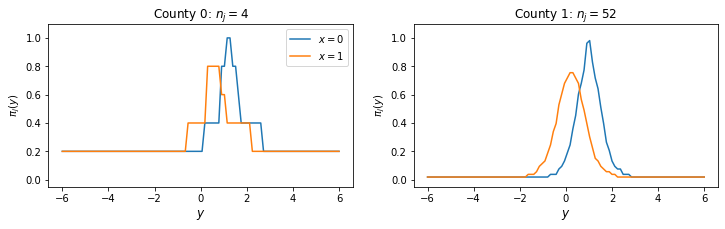

In [178]:
f = plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
k = 0
i = 2*k
county = x_test[i,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i]/(n_k+1),label = r'$x ={}$'.format(x_test[i,0].astype('int')))

county = x_test[i+1,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i+1]/(n_k+1),label = r'$x ={}$'.format(x_test[i+1,0].astype('int')))
plt.xlabel('$y$',fontsize = 12)
plt.ylabel(r'$\pi_j(y)$')
plt.ylim(-0.05,1.1)
plt.title('County {}: $n_j = {}$'.format(county,n_k))
plt.legend()

plt.subplot(1,2,2)
k = 1
i = 2*k
county = x_test[i,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i]/(n_k+1),label = r'$x ={}$'.format(x_test[i,0].astype('int')))

county = x_test[i+1,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i+1]/(n_k+1),label = r'$x ={}$'.format(x_test[i+1,0].astype('int')))
plt.xlabel('$y$',fontsize = 12)
plt.ylabel(r'$\pi_j(y)$')
plt.ylim(-0.05,1.1)
plt.title('County {}: $n_j = {}$'.format(county,n_k))
f.savefig('plots/radon_big.pdf', bbox_inches='tight')

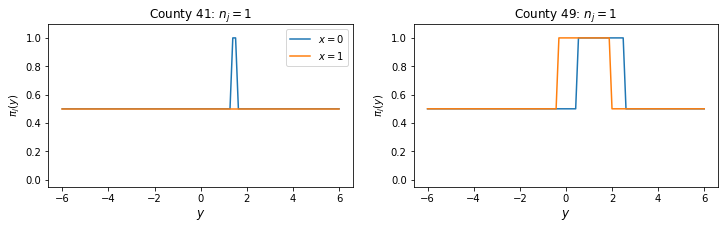

In [179]:
f = plt.figure(figsize = (12,3))
plt.subplot(1,2,1)
k = 41
i = 2*k
county = x_test[i,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i]/(n_k+1),label = r'$x ={}$'.format(x_test[i,0].astype('int')))

county = x_test[i+1,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i+1]/(n_k+1),label = r'$x ={}$'.format(x_test[i+1,0].astype('int')))
plt.xlabel('$y$',fontsize = 12)
plt.ylabel(r'$\pi_j(y)$')
plt.ylim(-0.05,1.1)
plt.title('County {}: $n_j = {}$'.format(county,n_k))
plt.legend()

plt.subplot(1,2,2)
k = 49
i = 2*k
county = x_test[i,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i]/(n_k+1),label = r'$x ={}$'.format(x_test[i,0].astype('int')))

county = x_test[i+1,1].astype('int')
n_k = n_groups[county].astype('int')
plt.plot(y_plot,pi_cb[i+1]/(n_k+1),label = r'$x ={}$'.format(x_test[i+1,0].astype('int')))
plt.xlabel('$y$',fontsize = 12)
plt.ylabel(r'$\pi_j(y)$')
plt.ylim(-0.05,1.1)
plt.title('County {}: $n_j = {}$'.format(county,n_k))
f.savefig('plots/radon_small.pdf', bbox_inches='tight')

### LMER

In [44]:
import statsmodels.formula.api as smf
d = {'log_radon': y, 'floor': x[:,0],'county':x[:,1]}
data = pd.DataFrame(data=d)

md = smf.mixedlm("log_radon ~ floor", data, groups=data["county"], re_formula="~floor")
%time mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

CPU times: user 1.52 s, sys: 250 ms, total: 1.77 s
Wall time: 301 ms
           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  log_radon 
No. Observations:   919      Method:              REML      
No. Groups:         85       Scale:               0.5138    
Min. group size:    1        Log-Likelihood:      -1047.2140
Max. group size:    116      Converged:           Yes       
Mean group size:    10.8                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          1.495    0.052 28.576 0.000  1.392  1.597
floor             -0.655    0.086 -7.650 0.000 -0.823 -0.487
Group Var          0.114    0.047                           
Group x floor Cov -0.041    0.055                           
floor Var          0.108    0.115                           

